# CMSC 320 Final Project
## Molly Tarter, Onur Gunduz, Daniel Wang

In [1]:
# Modules
import pandas as pd
import requests
from datetime import datetime, timezone # for time column and EST timezone conversion
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## Checkpoint 1

In [2]:
# API URL and params in case request gets denied
api_url = "https://developer.nrel.gov/api/pvwatts/v8.json" # endpoint with the argivoltaics data
params = {
    'api_key': 'LMpKxIwqBHBN9TJ9x4qtzhR2cD6mQUpZXBAURgbb',
    'system_capacity' : 0.05,
    'module_type' : 0,
    'losses' : 0,
    'array_type' : 0,
    'tilt' : 0,
    'azimuth' : 0,
    'lat' : 38.972360, # Maryland latitude
    'lon' : -76.937732, # Maryland longitude
    'timeframe' : 'hourly' # dataset is hourly, not monthly or annually
}

In [3]:
response = requests.get(api_url, params = params)
json = response.json()
outputs = json['outputs']
current_time = datetime.now(timezone.utc)
length = len(outputs['ac'])
# useful to know : 720 hours is a month, dataset shifts every hour
times = pd.date_range(end=current_time, periods=length ,freq='h')
hourly_data = {
    'Time EST' : times,
    'Hourly alternating current system output(Wac)' : outputs['ac'],
    'Hourly plane of array irradiance(W/m2)' : outputs['poa'],
    'Hourly beam normal irradiance(W/m2)' : outputs['dn'],
    'Hourly direct current array output(Wdc)' : outputs['dc'],
    'Hourly diffuse irradiance(W/m2)' : outputs['df'],
    'Hourly ambient temperature(C)' : outputs['tamb'],
    'Hourly module temperature(C)' : outputs['tcell'],
    'Hourly windspeed(m/s)' : outputs['wspd'],
    'Hourly albedo values' : outputs['alb']
} # created dictionary with hourly data from the dataset
df = pd.DataFrame(hourly_data) # created dataframe with the dictionary
df['Time EST'] = df['Time EST'].dt.tz_convert('US/Eastern') # want the time to reflect the current time (EST)
df.set_index('Time EST', inplace=True) # make the time the first column
df.to_csv('agrivoltaics.csv', index=True) # CSV file created

## Checkpoint 2

In [4]:
# Data preprocessing
# (a) Import - already done in previous cells
# (b) Parse - already done in previous cells (data types handled by pandas automatically)
# (c) Organize - additional organization steps below

# Check data types of columns
print("DataFrame data types:")
print(df.dtypes)

# Basic statistics of the dataset
print("\nDataset statistics:")
print(df.describe())

# Check for any missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Add some useful derived columns
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek

# Calculate efficiency (DC to AC conversion)
df['System_Efficiency'] = (df['Hourly alternating current system output(Wac)'] / 
                          df['Hourly direct current array output(Wdc)'] * 100)

# Sort index to ensure chronological order
df.sort_index(inplace=True)

print("\nUpdated DataFrame columns:")
print(df.columns.tolist())


DataFrame data types:
Hourly alternating current system output(Wac)    float64
Hourly plane of array irradiance(W/m2)           float64
Hourly beam normal irradiance(W/m2)              float64
Hourly direct current array output(Wdc)          float64
Hourly diffuse irradiance(W/m2)                  float64
Hourly ambient temperature(C)                    float64
Hourly module temperature(C)                     float64
Hourly windspeed(m/s)                            float64
Hourly albedo values                             float64
dtype: object

Dataset statistics:
       Hourly alternating current system output(Wac)  \
count                                    8760.000000   
mean                                        8.000985   
std                                        11.763435   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                   

Dataset Dimensions:
Number of entries: 8760
Number of features: 14


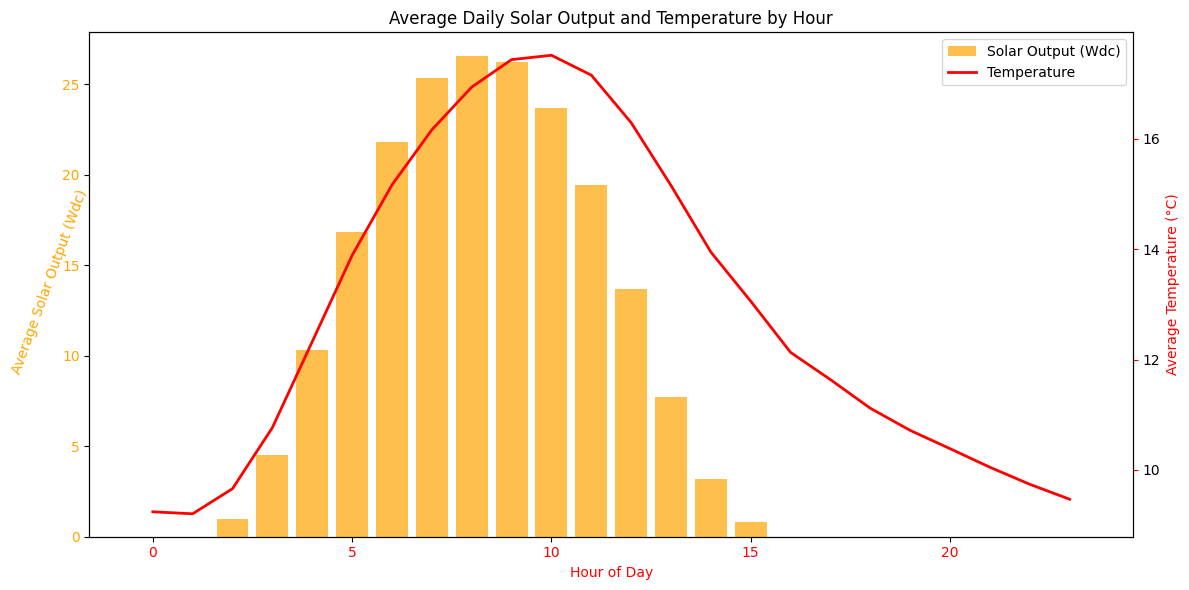

In [20]:
# Basic Data Exploration and Summary Statistics

# 1. Dataset Size and Feature Analysis
print("Dataset Dimensions:")
print(f"Number of entries: {len(df)}")
print(f"Number of features: {len(df.columns)}")

# Create a bar plot showing hourly solar output and temperature
plt.figure(figsize=(12, 6))
daily_avg = df.groupby('Hour').agg({
    'Hourly direct current array output(Wdc)': 'mean',
    'Hourly ambient temperature(C)': 'mean'
})

ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot solar output
ax1.bar(daily_avg.index, daily_avg['Hourly direct current array output(Wdc)'], 
        color='orange', alpha=0.7, label='Solar Output (Wdc)')
ax1.set_xlabel('Hour of Day', color='red')
ax1.set_ylabel('Average Solar Output (Wdc)', color='orange', rotation=70)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.tick_params(axis='x', labelcolor='red')

# Plot temperature line
ax2.plot(daily_avg.index, daily_avg['Hourly ambient temperature(C)'], 
         color='red', linewidth=2, label='Temperature')
ax2.set_ylabel('Average Temperature (°C)', color='red')
ax2.tick_params(axis='y', color='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Average Daily Solar Output and Temperature by Hour')
plt.tight_layout()
plt.show()

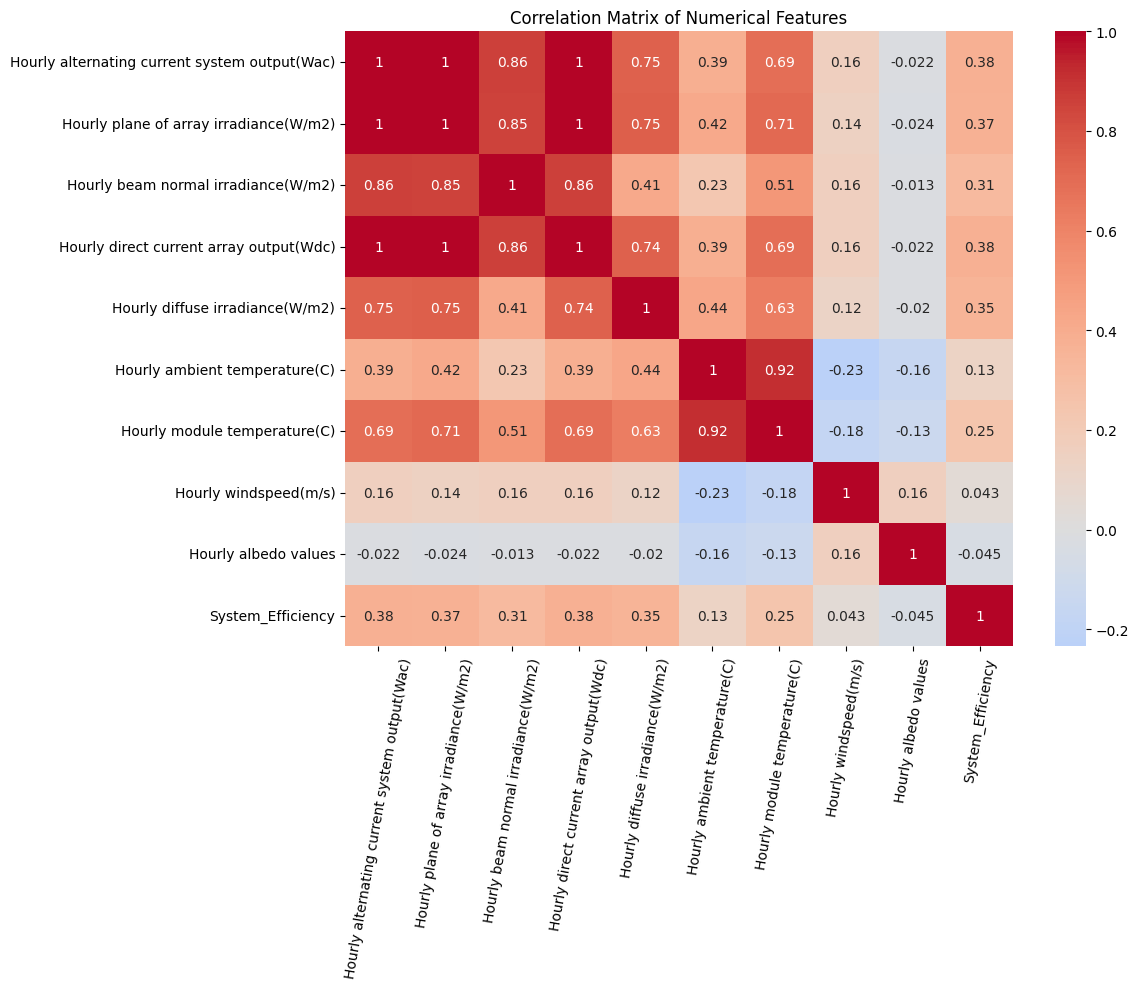


Hypothesis Test - Seasonal Variation in Solar Output:
F-statistic: 44.6078
P-value: 1.8525e-95

Mean DC output by month:
Time EST
1      6.897062
2      4.987387
3      4.020563
4      4.732017
5      5.921063
6      8.738940
7     10.451988
8     11.294962
9     12.319351
10    11.837878
11    10.412774
12     8.654915
Name: Hourly direct current array output(Wdc), dtype: float64

Analysis - Temperature Impact on System Efficiency:
Correlation coefficient: 0.1313
P-value: 3.0865e-18

Hypothesis Test - Morning vs Afternoon Efficiency:
Morning mean efficiency: 95.35%
Afternoon mean efficiency: 88.15%
T-statistic: 19.2605
P-value: 2.6750e-78

Land Use Efficiency Analysis:
Average daily energy production per unit area: 0.19 kWh


In [24]:
# 2. Correlation Analysis
# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

# 1. Analyze seasonal patterns in solar output
seasonal_means = df.groupby(df.index.month)['Hourly direct current array output(Wdc)'].mean()

# Remove any NaN values before running statistical tests
monthly_groups = [group['Hourly direct current array output(Wdc)'].dropna().values 
                 for name, group in df.groupby(df.index.month)]
# Only include groups with data
valid_groups = [group for group in monthly_groups if len(group) > 0]

if len(valid_groups) > 1:  # Need at least 2 groups for ANOVA
    f_stat, p_val = stats.f_oneway(*valid_groups)
    print("\nHypothesis Test - Seasonal Variation in Solar Output:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.4e}")
else:
    print("\nInsufficient data for seasonal analysis")

print("\nMean DC output by month:")
print(seasonal_means)

# 2. Correlation between temperature and system efficiency
# Remove rows where either value is NaN
temp_eff_data = df[['Hourly ambient temperature(C)', 'System_Efficiency']].dropna()
if len(temp_eff_data) > 0:
    temp_eff_corr = stats.pearsonr(temp_eff_data['Hourly ambient temperature(C)'], 
                                  temp_eff_data['System_Efficiency'])
    print("\nAnalysis - Temperature Impact on System Efficiency:")
    print(f"Correlation coefficient: {temp_eff_corr[0]:.4f}")
    print(f"P-value: {temp_eff_corr[1]:.4e}")
else:
    print("\nInsufficient data for temperature-efficiency correlation")

# 3. Compare morning vs afternoon efficiency
df['Hour'] = df.index.hour
morning = df[df['Hour'].between(6,11)]['System_Efficiency'].dropna()
afternoon = df[df['Hour'].between(12,17)]['System_Efficiency'].dropna()

if len(morning) > 0 and len(afternoon) > 0:
    t_stat, p_val = stats.ttest_ind(morning, afternoon)
    print("\nHypothesis Test - Morning vs Afternoon Efficiency:")
    print(f"Morning mean efficiency: {morning.mean():.2f}%")
    print(f"Afternoon mean efficiency: {afternoon.mean():.2f}%")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4e}")
else:
    print("\nInsufficient data for morning vs afternoon comparison")

# 4. Calculate land use efficiency metric
daily_energy = df['Hourly alternating current system output(Wac)'].resample('D').sum()
if len(daily_energy) > 0:
    land_efficiency = daily_energy.mean() / 1000  # kWh per day per unit area
    print("\nLand Use Efficiency Analysis:")
    print(f"Average daily energy production per unit area: {land_efficiency:.2f} kWh")
else:
    print("\nInsufficient data for land use efficiency calculation")

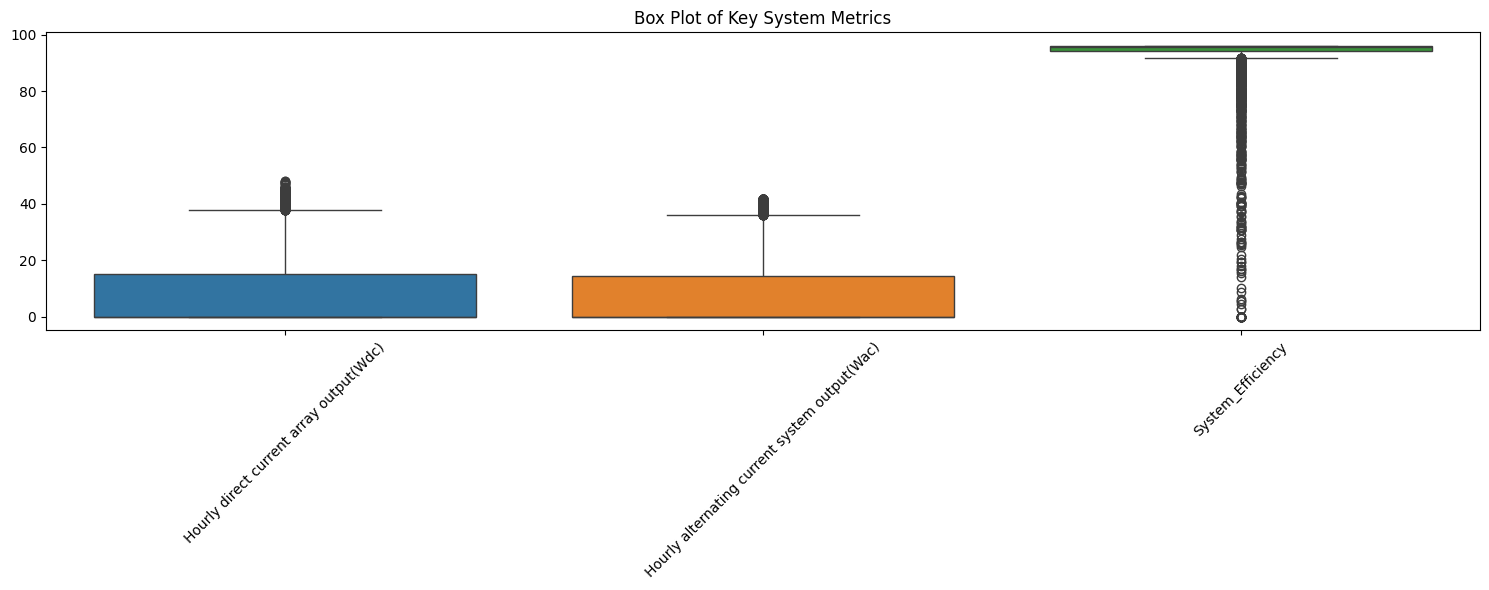


Number of outliers (|z-score| > 3) in each numerical column:
656


In [8]:
# 3. Outlier Analysis using Box Plots
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[['Hourly direct current array output(Wdc)', 
                     'Hourly alternating current system output(Wac)', 
                     'System_Efficiency']])
plt.title('Box Plot of Key System Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate Z-scores for numerical columns to identify outliers
z_scores = stats.zscore(df[numerical_cols])
outliers = (abs(z_scores) > 3).sum()
print("\nNumber of outliers (|z-score| > 3) in each numerical column:")
print(outliers)